<a href="https://colab.research.google.com/github/hsscholte/psyForum/blob/master/PsychForum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Psyforum Tutorial 1: Training a deep neural network (v1.4)
Lynn Sörensen & H.Steven Scholte

### Welcome! 
In this tutorial you will learn how to train a convolutional deep neural network (DCNN) on a simple object recognition task.

You will 
* build a Resnet model and look at its architecture <br/>
* train it on CIFAR10 <br/>
* ...with different learning schedules and observe the effects <br/>

next, you will
* design your own model and training scheme to get an optimal classification on a task. 

This tutorial is also going to get you acquainted with a dataset and a model architecture that will be used in a later tutorial. 

#### Some extra information:
There are different types of exercises throughout this tutorial, including:

- <font color='darkorange'><b>ToDos</b></font> : short programming exercises 
- <font color='cornflowerblue'><b>ToThinks</b></font>: questions about the (preceding) text/material

Sometimes, you also encounter <font color='limegreen'><b>Tips and Tricks</b></font>, which may contain advice, more information on a specific topic, or links to relevant websites or material.

#### GPU support
Don't forget to change your runtime type to GPU accelerator if you want to train these model. Click on `Runtime` above this notebook in the Colab environment and then on `Change Runtime Type`. Set Hardware accelerator to `GPU`.




### Let's start!

With importing the necessary packages:

In [0]:
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.models import Model
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.model_selection import train_test_split



Using TensorFlow backend.


And connect our google drive!

In [0]:
from google.colab import drive

drive.mount('/gdrive', force_remount=True)

And lets create a directory in your gdrive to store the models

In [0]:
mkdir "/gdrive/My Drive/CCN2019"

And define some useful functions for later!

In [0]:
def save_pickle(obj, name):
    try:
        filename = open(name + ".pickle","wb")
        pickle.dump(obj, filename)
        filename.close()
        return(True)
    except:
        return(False)


def load_pickle(filename):
    return pickle.load(open(filename, "rb"))
  
def plot_training(history, title=None):
  epochs = len(history.history['loss'])
  if 'lr' in history.history:
    fig, ax = plt.subplots(1, 3, figsize=(20,5))
    ax = ax.flatten()
    ax[0].plot(np.arange(epochs), np.transpose([history.history['loss'], history.history['val_loss']]))
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('loss')
    ax[0].set_ylim([0,3])
    ax[0].legend(['training', 'validation'])

    ax[1].plot(np.arange(epochs), np.transpose([history.history['acc'], history.history['val_acc']]))
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('accuracy')
    ax[1].set_ylim([0,1])
    ax[1].legend(['training', 'validation'])
    
    ax[2].plot(np.arange(epochs), history.history['lr'])
    ax[2].set_xlabel('epochs')
    ax[2].set_ylabel('learning rate')
    #ax[2].set_ylim([0,1])
  else:
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax = ax.flatten()
    ax[0].plot(np.arange(epochs), np.transpose([history.history['loss'], history.history['val_loss']]))
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('loss')
    ax[0].set_ylim([0,3])

    ax[1].plot(np.arange(epochs), np.transpose([history.history['acc'], history.history['val_acc']]))
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('accuracy')
    ax[1].set_ylim([0,1])
    fig.legend(['training', 'validation'])
  if title:
    fig.suptitle(title)
  fig.show()


## Part 1: Train a network on a simple object recognition task with different training schemes
In this part of the tutorial, you will be training a DCNN to solve object categorization on [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). We will use this dataset because it is relatively quick to train and still allows you to observe interesting behavior. The specific version of ResNet is based on [ResNetCifar10](http://www.pabloruizruiz10.com/resources/CNNs/ResNet-on-CIFAR10.pdf).

The logic of this part of the tutorial will be that you observe that effects of different choices (e.g. learning rate, data augmentation) that you make when you decide to train a DCNN from scratch. Training a DCNN can be tricky and the interaction between different decisions difficult to anticipate. 

Our goal for the first part is to replicate the training from the Resnet paper, one of the most successful architectures that is still widely used to day, despite its relatively old age for the deep learning community. To do this, we will be adding component by component to our training and obeserve in how it helps. 

So let's get started!

For all of the following experiments, we need:
* A stimulus set - CIFAR10
* A ResNet architecture




### 1.1 Stimulus set: CIFAR10
The CIFAR10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

This dataset is a standard benchmark in the Computer vision community to benchmark new architecture and training regimes.

<font color='darkorange'><b>ToDo:</b></font> Fill in the missing parts in the code below by replacing the 'FILL'.
Check out the objects. Plot a couple of examples for every category.

In [0]:
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# How many classes are there?

# num_classes = FILL
num_classes = 10

# Plots some examples here.
num_examples = 5
fig, ax = plt.subplots(num_examples, num_classes, figsize=(20,10))
for c in range(num_classes):
  class_idx = np.where(y_train == c)[0] # for a given class
  for e in range(num_examples): #pick some random examples from the training set
    # ax[e,c].imshow(FILL) 
    ax[e,c].imshow(x_train[class_idx[np.random.randint(len(class_idx))],:,:,:]) 
    ax[e,c].axis('off')




### 1.2 Data preparation
Humans and networks need different inputs and labels. Comparable to the range of light intensities that we are able to perceive, we need to transfer the images into a space where the networks can easily compute on them. This means, we will have to convert our images to have values between 0 and 1. 

<font color='cornflowerblue'><b>ToThink:</b></font> Why do you think the network can deal better with inputs between 0-1?




ANSWER: Inputs in a bounded range allow the network to learn and find weights that are not too extreme. Since we're going to be multiplying (weights) and adding to (biases) these initial inputs in order to cause activations that we then backpropogate with the gradients to train the model.

We'd like in this process for each feature to have a similar range so that our gradients don't go out of control.


<font color='darkorange'><b>ToDo:</b></font> Fill in the missing parts in the code below by replacing the 'FILL'.

In [0]:
# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
# x_train = x_train.astype('float32') / FILL
# x_test = x_test.astype('float32') / FILL

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


While we have an easy time understanding the label 'bird', we need to express categories as numbers for the network. The next step will be to also express the labels of the target category as a 1-hot-vector. This just means that you have a vector with zeros corresponding to all labels and you put a 1 for the right target category. Fortunately, Keras has a nice set of 'utils' to help us with that. For example keras.utils.to_categorical converts a class vector of integers to a binary class matrix.

<font color='darkorange'><b>ToDo:</b></font> Look uo how to use this function and fill in the correct arguements below! 

In [0]:
# Convert class vectors to binary class matrices.
# y_train = keras.utils.to_categorical(FILL)
# y_test = keras.utils.to_categorical(FILL)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

### 1.3 Validation set

As a last step, we'll set aside some of our training data as a validation dataset. This allows us to estimate how well our current model performs without touching the test set. 

<font color='cornflowerblue'><b>ToThink:</b></font> Do you recall why it is useful to have a validation set?



ANSWER: A validation set gives you an estimate of how well your current solution of weights will generalize to the test set.

In [0]:
# We take here 10% of our training set as a validation set. 

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=3) # 30k train, 10k val

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print('y_train shape:', y_train.shape)

print('x_val shape:', x_val.shape)
print(x_val.shape[0], 'val samples')
print('y_val shape:', y_val.shape)






<font color='limegreen'><b>Tips and Tricks</b></font>: Here we use a function from sklearn, this is one way to do it. Keras also allows you to make a validation set on the fly with an argument validationSplit in the [ImageDataGenerator class](https://keras.io/preprocessing/image/).

Notice that we also still have a test set that we obtained when we loaded cifar10. Below we inspect its dimensions:

In [0]:
print('x_test shape:', x_test.shape)
print(x_test.shape[0], 'test samples')
print('y_test shape:', y_test.shape)

<font color='cornflowerblue'><b>ToThink:</b></font> Why do you think we have 3 datasets, train, validate and test?

### 1.4 Resnet architecture

Now let's move on to the Resnet architecture. Since the images of CIFAR10 are only 32x32x3, the network to classify them cannot be too deep (remember the effect of convolution and pooling operations). For that reason, the authors of Resnet made a mini-version tailored to CIFAR10. The most important differences to the Resnet-version used on Imagenet (224x224x3 images) is the amount of blocks and the depth of the filters. Also, to somewhat reduce the performance we have made the network slightly smaller. 

<font color='darkorange'><b>ToDo:</b></font> Go over the definitions below and make sure to understand how it works.

In [0]:
# Below you can see the definition of a resnet block. 

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    # This is how you defince a 2D convolutional layer. 
    # At this point this is just a pre-defined function and not a layer yet!
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer= keras.regularizers.l2(1e-4))
    # This is where we start to chain the layers together.
    x = inputs # any block will start with the inputs given to this function.
    if conv_first: # This if-else statement refers to that there are two-ways of constructing the Resnet-block.
        x = conv(x) # Append the conv function from above to the input. 
        if batch_normalization:
            x = BatchNormalization()(x) # Here we add the Batchnormalization in the same way. 
        if activation is not None:
            x = Activation(activation)(x) # And similarly for the Activation function.
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x
  
  # These operations will be repeated many times and as result 


In [0]:
# and this is how the model is put together.
  
def resnet_v1(input_shape, depth=8, num_classes=10):
    """ResNet Version 1 Model builder [a]
    Adapted from https://keras.io/examples/cifar10_resnet/
    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet10 0.14M
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor (dim1,dim2,channels)
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    # if (depth - 2) % 6 != 0:
    #    raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs) 
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            # This defines the first branch in which all the weight layer are. 
            y = resnet_layer(inputs=x, 
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y, 
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y]) # Here the first branch is added to the residual.
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model
  

<font color='darkorange'><b>ToDo:</b></font> Build the model with the functions above (by using the default settings!)


In [0]:
# Build the model
# FILL
model = resnet_v1(input_shape=input_shape)

# ... and show the architecture
model.summary()

Voilà, your model!
So what is going on inside of a Resnet-Model?

![alt text](https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png) 

Above the same operations are shown as a graphic. x refers to the current end of the model, that can be any layer. A weight later would a Conv2D layer. relu refers to the activation function. In our case, this is also integrated in the Conv2D layer (see the activation argument in the resnet layer function). 

<font color='cornflowerblue'><b>ToThink:</b></font>  Can you see how this schematic fits with the model.summary output? 
How many of these blocks are there in total? Follow the Add operation!



ANSWER: There are 3 blocks in total.

There are range of different resnet types with varying depths! The depths in the name is determined by the amount of Convolutional and Dense layers.

<font color='cornflowerblue'><b>ToThink:</b></font> In the current case, how many convolutional and dense layers are there respectively?



ANSWER: There are 9 convolutional and 1 dense layer, making it a 10 layer network.

<font color='limegreen'><b>Tips and Tricks</b></font>: There is a range of models available provided by Keras with pretrained weights on ImageNet that are easy to use such as VGG or Inception. For more info see [here](https://keras.io/applications/#available-models).

### 1.5 Training options

Our model currently has random weights, that means, it has not been trained to do any task. Let's see what that means. For example if we have it classify the CIFAR10 training set.

#### 1.5.0 model.compile
Before a freshly assembled model can be trained or tested, it first needs to be compiled. That means we add our loss function (e.g. categorical_crossentropy), a training optimizer (remember stochastic gradient descent!) and a metric to compare between the model answer and the true answer (accuracy).


<font color='darkorange'><b>ToDo:</b></font> Check out https://keras.io/optimizers/ for an overview of all available optimizers and their defaults. Set up the compile function with categorical crossentropy, stochastic gradient descent and accuracy as a metric!


In [0]:
# Fill = keras.selectOptimizers.FILL()
# modelCC.compile(loss=FILL, optimizer=FILL, metrics=[FILL]) 

sgd = keras.optimizers.SGD()
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['acc']) 
scores = model.evaluate(x_train, y_train, verbose=1)

print('Training loss:', scores[0])
print('Training accuracy:', scores[1])

<font color='cornflowerblue'><b>ToThink:</b></font> What does the training loss mean? Is the training accuracy like you would expect and if so, why? 



#### 1.5.1 Training with standard gradient descent and a large batch size
Now let's start with teaching the model the task of distinguishing the 10 different object categories in CIFAR10. 

In the lecture, we have seen that a big part of successful training is choosing the right batch size, gradient update & learning rate at the right moment in time. Below, we are going to train our model in different ways and change this part in our training. 

As a result of how we set up our model above (model.compile ...), we accepted the default parameters of the SGD optimizer. The gradient updates will follow the steepest gradient throughout our entire training. 

<font color='cornflowerblue'><b>ToThink:</b></font> Do you think this is a good strategy?



ANSWER: In general, there is nothing wrong about accepting the default values. Yet, as we talked about in the lecture, the basic concept of gradient descent is great but there might be some smarter ways to selet these values. Figuring out which these are, in such a way that the model is not overfitted is a central skill.

<font color='darkorange'><b>ToDo:</b></font> Can you set up the training below with the model.fit() function? Remember, we set aside a validation dataset, to evaluate how well our model will generalize to the test set! Choose a batch-size of 5000 and run it for 30 epochs!

<font color='limegreen'><b>Tips and Tricks</b></font>: In the snippet of code there is already a modelcheckpoint set up for you. This will safe the currently best-performing model automatically. 

In [0]:
# epochs = FILL
# batch_size = FILL
epochs = 50
batch_size = 5000

# Training of the model
# history_151 = model.fit(FILL, shuffle=True)  
history_151 = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val), shuffle=True)

# Save the outcomes
model.save_weights('/gdrive/My Drive/CCN2019/weights_151.h5')
save_pickle(history_151, '/gdrive/My Drive/CCN2019/history_151')

The history object contains an overview of the training. With that you can inspect how the training went. 

In [0]:
plot_training(history_151, title='1.5.1 Training with a static learning rate, large batch size')

So what do we see here? Neither the performance on the training or validation set increased in an impressive maner. 

<font color='cornflowerblue'><b>ToThink:</b></font> This is an effect of the large batch size. Why?







#### 1.5.2 Training with standard gradient descent and a small batch size


<font color='darkorange'><b>ToDo:</b></font> We will now reduce our batchsize to 36 and evaluate the performance again. Keep, for once, 50 epochs (and get some coffee).

In [0]:
# epochs = FILL
# batch_size = FILL
epochs = 50
batch_size = 36

# Training of the model
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['acc']) 

# history_152 = model.fit(FILL, shuffle=True)  
history_152 = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val), shuffle=True)

# Save the outcomes
model.save_weights('/gdrive/My Drive/CCN2019/weights_152.h5')
save_pickle(history_152, '/gdrive/My Drive/CCN2019/history_152')


The history object contains an overview of the training. With that you can inspect how the training went. 

In [0]:
plot_training(history_152, title='1.5.2 Training with a static learning rate, small batch size')

So what do we see here? While the model continued to fit the training set (contrary to 1.5.1). The corresponding measures on the validation improved substantially less, and also sometimes deteriorated. 

<font color='cornflowerblue'><b>ToThink:</b></font> Which scenario from the lecture could this correspond to? For later epochs, is the learning rate too small, too big, way too big or equal to the optimal learning rate?








ANSWER: For later epochs, this corresponds to choosing a too big learning rate since the training actually doesn't improve the performance over time. The big jumps in the loss also indicate that it is making too big steps after a single epoch.

#### 1.5.3 Training with momentum

This went *ok*. But we can do better! Do you remember the difficult landscape from the lecture? There might be smarter ways how we can travel through this landscape! 

<font color='cornflowerblue'><b>ToThink:</b></font> Can you describe in your own words, how we traveled the landscape in the last training? What does the learning rate mean in this analogy?






ANSWER: In the last training, we have always taken the same step size and followed the steepest slope. The learning rate corresponds to the size of the update, so a distance in the landscape. 

A start could be that we develop a better decision rule for which direction to follow. This means that it might not always be the best idea to follow the currently steepest gradient. 

This is exactly what training stochastic gradient descent with momentum does! The intuition behind is that when there was a certain direction that continuously had a gradient to learn from, this direction gains more weight. This can be imagined like a ball rolling downhill.

<font color='darkorange'><b>ToDo:</b></font> Can you set up a new model, compile it with a Nesterov-momentum of 0.9? You can keep all the other parameters the same. Train the model and see how it compares to the other training?

In [0]:
epochs = 50
batch_size = 36
 
# model_153 = FILL
# sgd_custom = keras.optimizers.SGD(FILL) 
# model_153.compile(FILL)
  
model_153 = resnet_v1(input_shape=input_shape)
sgd_custom = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True) 
model_153.compile(loss='categorical_crossentropy',optimizer=sgd_custom,metrics=['accuracy'])

# history_153 = model.fit(FILL, shuffle=True)  
history_153 = model_153.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val), shuffle=True)

# Save the outcomes
model.save_weights('/gdrive/My Drive/CCN2019/weights_153.h5')
save_pickle(history_153, '/gdrive/My Drive/CCN2019/history_153')

In [0]:
plot_training(history_153, title='1.5.3 Training with Nesterov-momentum')


This went a bit better. Do you remember the adaptive optimizers from the lecture (such as Adam, Adagrad and RMSprop)? These can be a great option as well when you don't know the right hyperparameters yet.

Please check out [this website](https://cs231n.github.io/neural-networks-3/#loss) for a insightful description as well as the list of keras optimizers mentioned above.

So taken together, we've seen that adding momentum helps your model to train and optimize.  



#### 1.5.4 Training with learning rate decay

Above we saw that we can deal with the bumpy loss landscapes in more optimal ways by using an optimizer to compute the best gradients to follow. However, these gradients are ultimately still bound to the specified learning rate (e.g. 0.01) for performing the update on the weights. Now we are going to explore some ways in which we can adapt the learning rate over time.

A sensible way to start could be to reduce the learning rate at every iteration a little bit. This is refferd to as learning rate decay. 

<font color='darkorange'><b>ToDo:</b></font> Can you set up a new model with learning rate decay with an initial learning rate of 0.01 and a decay of 1e-6? Again, you can keep all the other parameters the same. Train the model and see how it compares to the other training?




In [0]:
# to realise: lr *= (1. / (1. + self.decay * self.iterations))
epochs = 50
batch_size = 36

# model_154 = FILL
# sgd_custom = keras.optimizers.SGD(FILL) 
# model_154.compile(FILL)
# history_154 = model_153.fit(FILL, shuffle=True)

model_154 = resnet_v1(input_shape=input_shape)
sgd_decay = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True) 
model_154.compile(loss='categorical_crossentropy',optimizer=sgd_decay,metrics=['accuracy'])
history_154 = model_154.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_val, y_val),shuffle=True)

# Save the outcomes
model.save_weights('/gdrive/My Drive/CCN2019/weights_154.h5')
save_pickle(history_154, '/gdrive/My Drive/CCN2019/history_154')

In [0]:
history_154.history['lr'] =  0.01 *  (1. / (1. + 1e-6 * np.arange(1,epochs+1))) 
plot_training(history_154, title='1.5.4 Training with learning rate decay')



<font color='cornflowerblue'><b>ToThink:</b></font> How does the reduction in learning rate compare to the other scenarios with a fixed learning rate? 

ANSWER: Based on the training history, we see that they were less strong fluctuations at later epochs of the training. 

#### 1.5.5 Training with a fixed learning rate schedule

As we discussed in the lecture, learning rate is one of the crucial hyperparameters, which is subject to optimization. If you in turn would like to replicate another paper, they sometimes mention a learning rate schedule that is optimized for this specific architecture and dataset. 

<font color='darkorange'><b>ToDo:</b></font> Can you come up with your own learning rate schedule below? Again, you can keep all the other parameters the same. Once, you are done, look at the provided training outcomes!

In [0]:
epochs = 50
batch_size = 36

# model_155 = FILL
model_155 = resnet_v1(input_shape=input_shape)

# We stick to a common optimizer
sgd = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True) 
  
# def step_decay(epoch): 
#if epoch  < FILL:
#lrate=0.1
#elif epoch < FILL:
#lrate = 0.01
#else:
# lrate = 0.001
#  return lrate

def step_decay(epoch): 
  if epoch  < 10:
    lrate=0.1
  elif epoch < 30:
    lrate = 0.01
  else:
    lrate = 0.001
  return lrate

# and we hand the function to the training with acallback.
lr_reducer = keras.callbacks.LearningRateScheduler(step_decay)

model_155.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])
history_155 = model_155.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_val, y_val),shuffle=True, callbacks = [lr_reducer])

model_155.save_weights('/gdrive/My Drive/CCN2019/weights_155.h5')
save_pickle(history_155, '/gdrive/My Drive/CCN2019/history_155')    

In [0]:
plot_training(history_155, title='1.5.5 Training with a fixed learning rate schedule')


<font color='cornflowerblue'><b>ToThink:</b></font> Can you tell from the plot at which epochs the learning rate was changed?

ANSWER: Based on the dips and the third plot, you can see that it was changed in the 10th and 30th epoch.

<font color='darkorange'><b>ToDo:</b></font> Plot all our training histories in one plot!





In [0]:
# load_pickle('/gdrive/My Drive/CCN2019/history_151.pickle')
# load_pickle('/gdrive/My Drive/CCN2019/history_152.pickle')
# load_pickle('/gdrive/My Drive/CCN2019/history_153.pickle')
# load_pickle('/gdrive/My Drive/CCN2019/history_154.pickle')
# load_pickle('/gdrive/My Drive/CCN2019/history_155.pickle')

plot_training(history_151, title='1.5.1 Training with large batch size and a fixed learning rate schedule')
plot_training(history_152, title='1.5.2 Training with small batch size and a fixed learning rate schedule')
plot_training(history_153, title='1.5.3 Training momentum')
plot_training(history_154, title='1.5.4 Training learning rate decay')
plot_training(history_155, title='1.5.5 Training fixed learning rate schedule')



<font color='cornflowerblue'><b>ToThink:</b></font> Which one worked the best?

ANSWER: Based on the comparison, the fixed training schedule seemed to have worked best. This is likely due to the fact that this schedule had a late phase with a very small learing rate, which allowed for very fine adjustments and that this was lacking in the other trainings. Also, this fixed schedule was based on the data-set making it a hyper parameter that has been optimized. 

### Part 1: Interim conclusion
All of the examples above show that while keeping everything else the same, choosing the right hyperparameters can make a world of a difference. Usually, it pays off to invest some time and closely study the original papers and their chosen hyperparameters such as their optimization setup. Most likely, they have been optimized for this specific dataset and architecture!

Up next, we will have a look at another remedy against overfitting on your training set!





## Part 2: Data augmentation

The logic behing data augmentation is to change the training images in such a way that the signal (in our case the category specific information) stays unchanged but the noise gets varied (e.g. by mirroring an image). Like this the amount of training data get multiplied, which can benefit its generalizability. 




 

### 2.1 Keras data augmentation techiques 
There is a whole range of possible manipulations that come 'out of the box' with [keras ]( https://keras.io/preprocessing/image/) like flipping, rotating and normalizing the training images.

<font color='darkorange'><b>ToDo:</b></font> Perform a range of different data augmentation techniques on the same image and plot the outcome!

In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(FILL)

fig, ax = plt.subplots(1, 5, figsize=(10,5))
for c in range(5):
  FILL
  sample = next(gen) 
  ax[c].imshow(sample[0]) 
  ax[c].axis('off')
  
  

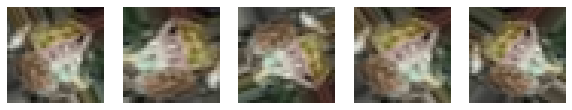

In [0]:
## SOLUTION
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=[0.8,1.2], horizontal_flip=True, rotation_range=90)
fig, ax = plt.subplots(1, 5, figsize=(10,5))
for c in range(5):
  gen = datagen.flow(x_train[4:5,:,:,:])
  sample = next(gen) 
  ax[c].imshow(sample[0]) 
  ax[c].axis('off')

### 2.2 Data augmentation in the paper
The idea of this tutorial is to mimic the ResNet training, which used **random cropping** as well as **horizontal flipping** during training and **central cropping** for testing on the validation set. Additionally, all images were **subtracted by the mean pixel mean** prior to training:

"We follow the simple data augmentation [...] for training: 4 pixels are padded on each side,
and a 32×32 crop is randomly sampled from the padded
image or its horizontal flip. For testing, we only evaluate
the single view of the original 32×32 image." (pp. 7, [Resnet paper](https://arxiv.org/pdf/1512.03385.pdf) by He et al. 2015)

Unfortunately, Keras does not come with this functionality, so we here give you a set of custom functions to do exactly that.
 

In [0]:
def CIFAR_crop(X, y,batch_size=1, crop = 'random'):

    if crop not in ["center", "random"]:
        raise ValueError('Invalid crop method {} specified.', crop)

    target_size = (32, 32)

    # Resize keeping aspect ratio
    # result shold be no smaller than the targer size, include crop fraction overhead
    #target_size_before_crop = (X.shape[1] / crop_fraction, X.shape[2] / crop_fraction)
    #ratio = max(target_size_before_crop[0] / X.shape[1], target_size_before_crop[1] / X.shape[2])
    #target_size_before_crop_keep_ratio = int(X.shape[1] * ratio), int(X.shape[2] * ratio)

    counter = 0
    while X.shape[0] - counter*batch_size > 0:

        X_batch = X[counter * batch_size: (counter + 1) * batch_size, :, :, :]
        y_batch = y[counter * batch_size: (counter + 1) * batch_size, :]

        X_batch = np.pad(X_batch, ((0,0),(4,4),(4,4),(0,0)), 'reflect')

        if crop == "center":
            left_corner = int(round(X_batch.shape[1] / 2)) - int(round(target_size[0] / 2))
            top_corner = int(round(X_batch.shape[2] / 2)) - int(round(target_size[1] / 2))
            X_batch = X_batch[:,left_corner: left_corner + target_size[0], top_corner: top_corner + target_size[1], :]

        elif crop == "random":
            left_shift = np.random.randint(0, int((X_batch.shape[1] - target_size[0])))
            down_shift = np.random.randint(0, int((X_batch.shape[2] - target_size[1])))

            X_batch = X_batch[:, left_shift: left_shift + target_size[0], down_shift: down_shift + target_size[1], :]

        # random flip from left to right
        idx = np.random.randint(2,size = batch_size)
        X_batch[idx==1,:,:,:] = np.flip(X_batch[idx==1,:,:,:],axis=2)

        counter = counter + 1
        if len(X) - (counter+1) * batch_size< 0: # After very last iterartion
            counter = 0

        yield X_batch, y_batch
        
 

<font color='limegreen'><b>Tips and Tricks</b></font>: Generators are a very useful to define routines to be executed for instance on an image dataset

`Generator functions allow you to declare a function that behaves like an iterator, i.e. it can be used in a for loop.` [PythonDocs](https://wiki.python.org/moin/Generators)


In [0]:
data_generator = CIFAR_crop(x_train, y_train, batch_size=len(x_train))


<font color='darkorange'><b>ToDo:</b></font> Get some samples for the generator and look at the images! 

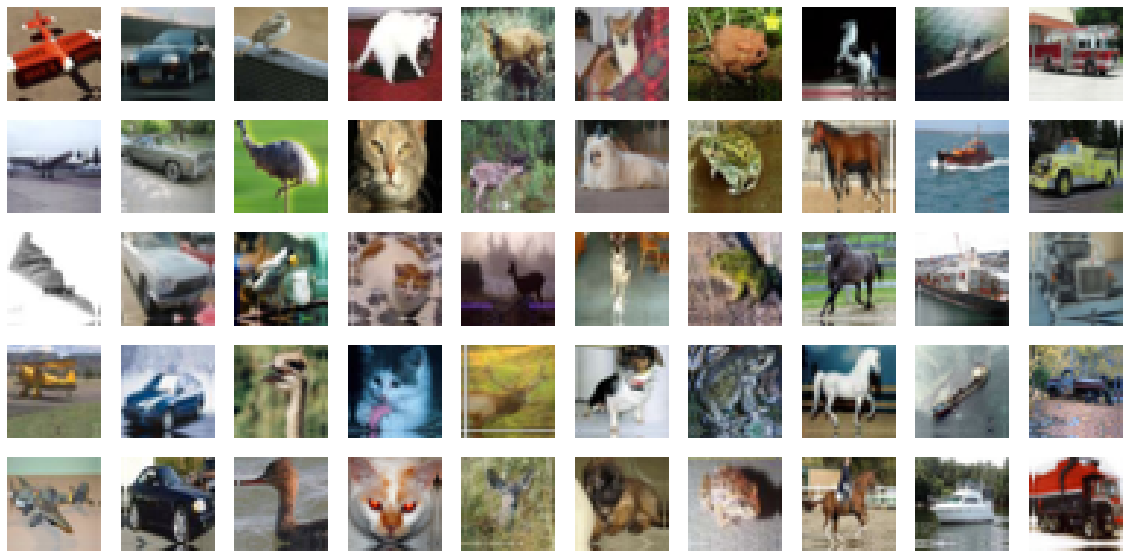

In [0]:
## SOLUTION
x_sample, y_sample = next(data_generator)
# Plot it.
fig, ax = plt.subplots(num_examples, num_classes, figsize=(20,10))
for c in range(num_classes):
  class_idx = np.where(np.where(y_sample ==1)[1] == c)[0] # for a given class
  for e in range(num_examples): #pick some random examples from the training set
    ax[e,c].imshow(x_sample[class_idx[np.random.randint(len(class_idx))],:,:,:]) 
    ax[e,c].axis('off')



It is common practice to center the dataset so that it will be easier for the network to learn from the distribution of outputs. Centering a dataset means that it has a mean of zeros in every color channel respectively.

<font color='darkorange'><b>ToDo:</b></font> We want to subtract the mean pixel value (from the training set) for a given color channnel in both the training and validation set. Write a function that does this!

In [0]:
def mean_subtract(x_train, x_test):
  FILL
  return x_train, x_test

In [0]:
## SOLUTION
# mean pixel subtraction: 

def mean_subtract(x_train, x_test):
  x_train_mean = np.mean(x_train, axis=0)
  x_train -= x_train_mean
  x_test -= x_train_mean # note that we are also subtracting the mean of the training set here.
  return x_train, x_test

### 2.3 Replication of ResNet18 training on CIFAR10  

Finally, let's try to directly copy the training in the paper for both the data augmentation mentioned above and combine it with everything you learnt about traning schemes:

<font color='darkorange'><b>ToDo:</b></font> Set up the following training scheme:

"We use a weight decay of 0.0001 and momentum of 0.9, [...]. These models are trained with a minibatch size of 128 on two GPUs. We start with a learning rate of 0.1, divide it by 10 at 32k and 48k iterations, and terminate training at 64k iterations, which is determined on a 45k/5k train/val split. " (pp. 7, [Resnet paper](https://arxiv.org/pdf/1512.03385.pdf))

<font color='limegreen'><b>Tips and Tricks</b></font>: 

*Iteration*: Dataset size divided by batch size. 

The batch size is specified for both GPUs, so the actual batch size is divided by 2.

<font color='darkorange'><b>ToDo:</b></font> Can you combine it with the data augmentation mentioned above?




In [0]:
# Define the learning rate schedule
# Define the model
# Define the compile function
  
## Data augmentation
# Subtract the mean from the datasets
x_train_m, x_val_m = mean_subtract(x_train, x_val)
  
#  the data generator
train_generator = CIFAR_crop(x_train_m, y_train, batch_size=batch_size, crop=FILL)
val_generator = CIFAR_crop(x_val_m, y_val, batch_size=batch_size, crop=FILL)

## train
history_230 = model_230.fit_generator(train_generator,
                                      steps_per_epoch= x_train.shape[0]//batch_size,
                                      epochs=FILL,
                                      validation_data=val_generator,
                                      validation_steps = x_val.shape[0]//batch_size,
                                      shuffle=True, callbacks = [lr_reducer])
# Save the results
model_230.save_weights('/gdrive/My Drive/CCN2019/weights_230.h5')
save_pickle(history_230, '/gdrive/My Drive/CCN2019/history_230')

In [0]:
## SOLUTION
def step_decay(epoch): # based on the paper
    if epoch * 351 < 32000:
        lrate=0.1
    elif epoch * 351 < 48000:
        lrate = 0.01
    else:
        lrate = 0.001
    return lrate

model_230 = resnet_v1(input_shape=input_shape)
lr_reducer = keras.callbacks.LearningRateScheduler(step_decay)

sgd = keras.optimizers.SGD(lr=0.1, decay=1e-4, momentum=0.9, nesterov=True) 
model_230.compile(loss='categorical_crossentropy',optimizer=sgd,
              metrics=['accuracy'])
x_train_m, x_val_m = mean_subtract(x_train, x_val)

train_generator = CIFAR_crop(x_train_m, y_train, batch_size=batch_size)
val_generator = CIFAR_crop(x_val_m, y_val, batch_size=batch_size)

history_230 = model_230.fit_generator(train_generator, 
                                      steps_per_epoch= x_train.shape[0]//batch_size,
                                      epochs=183,
                                      validation_data=val_generator,
                                      validation_steps = x_val.shape[0]//batch_size,
                                      shuffle=True, callbacks = [lr_reducer])

model_230.save_weights('/gdrive/My Drive/CCN2019/weights_230.h5')
save_pickle(history_230, '/gdrive/My Drive/CCN2019/history_230')

In [0]:
plot_training(history_230, title='2.3 Replication of ResNet18 training on CIFAR10')

<font color='cornflowerblue'><b>ToThink:</b></font> If you plot the training history, how does it compare to the paper? Note that the y-axis in the paper is labeled error, which is 1-accuracy.
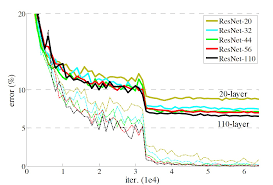




ANSWER: It looks pretty similar! The validation and training accuracy approximately end up in the same performance level as in the paper!

<font color='cornflowerblue'><b>ToThink:</b></font> What do the drops in the loss and accuracy represent?



ANSWERS: This is again a result of the training schedule. 

<font color='cornflowerblue'><b>ToThink:</b></font> This training regime seems to perform better that the ones we trained in part 1. Why do you think that is?

ANSWERS: This training not only had more epochs, it also had data augmentation, which prevented it from overfitting the training set. In addition, the authors of this paper have certainly invested a lot of time to find this optimal training schedule.

### Part 2: Interim conclusion
* Data augmentation is a powerful tool to avoid overfitting!
* It is possible to replicate deep learning papers and worth it if you want to achieve the best performance.
* You have just trained your first model at the state-of-the-art!


## Part 3: Transfer learning

The last parts of the tutorial we were training models from scratch, this means, their weights were randomly initialized. While this give you a lot of freedom, for bigger networks training on large-scale dataset, training takes a long time and can easily go wrong. Models that have been pretrained on a broad task (such as object categorization on ImageNet) are a useful way to start!

In the next part of the tutorial, we will be using pretrained models and customize them to a new task.





### 3.1 Pre-trained ResNet18 on ImageNet



In [0]:
# First we have to download a package containing a range of DCNNs trained on Imagenet
!pip install -U image-classifiers==0.2.2 #git+https://github.com/qubvel/classification_models.git
# The we load the remaining packages
import classification_models
from classification_models.resnet import ResNet18

In [0]:
# Then we can assemble the model and load the weights. 
# Thanks to this package this is very easy.
model = ResNet18((224, 224, 3), weights='imagenet')
model.summary()

<font color='cornflowerblue'><b>ToThink:</b></font> How does this Resnet18 compare to the other one? What do they have in common, what is different? 

*Hint*: Think about the size of the input images! <br/>
*Hint*: Look at the channel depth (last dimension of every layer) and how this changes with network depth.


### 3.2 5-category dataset
We are going to fine-tune this Resnet18 to distinguish between 5 categories: bird, cat, fire hydrant, frisbee and suitcase.

#### The dataset
This dataset was assembled as a part of a project on whether recurrent processing solves the problem of object segmentation during object recognition in humans and deep neural networks. You might wonder now, how can you adress this question with feedforward neural network? The background of this is, that recurrent computations in the brain are argued to represent a very deep feedforward computation that is folded up over time. Noor therefore uses deep neural networks of varying depth and examines how well the network can deal with object segmentation. She is going to tell you much more about that this tomorrow morning.

For now, we will finetune a Resnet18 on these object categories to prepare the networks for tomorrow's experiments!

As a start, let's build a function that loads in the data from all the directories!

In [0]:
# Let's load in the images

img_dir = '/gdrive/My Drive/image_cat/' # this assumes that you have loaded in the dataset in your local google drive folder.
train_dir = img_dir + 'train/'
img_generator =  ImageDataGenerator().flow_from_directory(train_dir, 
                                                          target_size=(224, 224),
                                                          batch_size=256,
                                                          class_mode='categorical',
                                                          shuffle=True)
examples = next(img_generator)


<font color='darkorange'><b>ToDo:</b></font> Have a look at the new dataset!

In [0]:
FILL

In [0]:
## SOLUTION
import numpy as np
import matplotlib.pyplot as plt
examples = next(img_generator)

# How many classes are there?
num_classes = 5 
# and look at it.
num_examples = 5
cats = ['Bird','Cat', 'Fire Hydrant', 'Frisbee', 'Suitcase']

fig, ax = plt.subplots(num_examples, num_classes, figsize=(12,10))
for c in range(num_classes):
  class_idx = np.where(np.where(examples[1] == 1)[1] == c)[0]# for a given class

  for e in range(num_examples): #pick some random examples from the training set
    ax[e,c].imshow(examples[0][class_idx[np.random.randint(0, len(class_idx)-1)],:,:,:]/255.) # We have to rescale the original images in order to display them. 
    ax[e,c].axis('off')
    if e == 0:
      ax[e,c].set_title(cats[c])

fig.tight_layout()

<font color='limegreen'><b>Tips and Tricks</b></font>: 
Different researchers perfom different kind of data preprocessing during their training of Imagenet. This makes that there is usually a custom preprocessing associated to the trained weights that shifts the values of the image in the expected range. If you do not transform your images that way, the network will not be able to recognize your images because it wasn't trained in this space.

Some researchers subtract the mean value of each color channel (cf. 2.2), some other also normalize it by dividing by the standard deviation of the training set. 

In our case, the network accepts value from 0-255 and this also happens to be the format in which we load the images in!

### 3.3 Test it on naive Resnet18 familiar with Imagenet

<font color='darkorange'><b>ToDo:</b></font> Find out (on a couple of images) how well the model predicts this dataset without being retrained.If you want you can plot the images and show the predicted labels.

<font color='limegreen'><b>Tips and Tricks</b></font>:  You will find the  keras.applications.imagenet_utils.decode_predictions function useful to make sense of the model predictions.



In [0]:
from keras.applications.imagenet_utils import decode_predictions

generator_images =  ImageDataGenerator().flow_from_directory(img_dir + 'val/',
                                                          target_size=(224,224),
                                                          batch_size=5,
                                                          class_mode='categorical',
                                                          shuffle=True)

imgs = FILL 

y = model.predict(imgs[0])

fig, ax = plt.subplots(1, len(imgs[0]), figsize=(12,7))
ax = ax.flatten()
for c in range(len(imgs[0])):
  ax[c].imshow(imgs[0][c]/255.) 
  ax[c].axis('off')
  ax[c].set_title(decode_predictions(y[c,np.newaxis,:])[0][0][1] +'\n' +  
                  str(decode_predictions(y[c,np.newaxis,:])[0][0][2]))

In [0]:
# SOLUTION
from keras.applications.imagenet_utils import decode_predictions

generator_images =  ImageDataGenerator().flow_from_directory(img_dir + 'val/',
                                                          target_size=(224,224),
                                                          batch_size=5,
                                                          class_mode='categorical',
                                                          shuffle=True)
imgs = next(generator_images)

y = model.predict(imgs[0])

fig, ax = plt.subplots(1, len(imgs[0]), figsize=(12,7))
ax = ax.flatten()
for c in range(len(imgs[0])):
  ax[c].imshow(imgs[0][c]/255.) 
  ax[c].axis('off')
  ax[c].set_title(decode_predictions(y[c,np.newaxis,:])[0][0][1] +'\n' +  
                  str(decode_predictions(y[c,np.newaxis,:])[0][0][2]))


<font color='cornflowerblue'><b>ToThink:</b></font> What do you see? And what does the network see? Does the network's classification make sense and is it certain of it? Can we learn from it whether our categories of interest are on the picture?

ANSWER: The network does classify objects that are on the provided images, however usually this does not fall in the categories we want to know about! 

### 3.4 Transfer learning with fine-tuning

For performing transfer learning, we will like in the last tutorial <br/>
* prepare our data for training & testing. <br/>
* setup the optimization & learning rate adaptation <br/>
* perform the training

In addition, we will also customize our architecture to suit the new target categories (5 vs. 1000)

There are also some general differences to the first two parts of this tutorial such as the amount of epochs to train on and the chosen learning rate. I'll comment on these differences below.


#### 3.4.1 Data augmentation

Unfortunately, keras cannot perform random cropping while loading images from a directory. For that reason, we have to create a monkey patch to emulate the load_img function. This in bad practice and I would avoid this under all circumstances.

In [0]:
import keras
import random
def load_and_crop_img(path, grayscale=False, color_mode='rgb', target_size=None,
                      interpolation='nearest'):
    """Wraps keras_preprocessing.image.utils.loag_img() and adds cropping.
    Cropping method enumarated in interpolation
    # Arguments
        path: Path to image file.
        color_mode: One of "grayscale", "rgb", "rgba". Default: "rgb".
            The desired image format.
        target_size: Either `None` (default to original size)
            or tuple of ints `(img_height, img_width)`.
        interpolation: Interpolation and crop methods used to resample and crop the image
            if the target size is different from that of the loaded image.
            Methods are delimited by ":" where first part is interpolation and second is crop
            e.g. "lanczos:random".
            Supported interpolation methods are "nearest", "bilinear", "bicubic", "lanczos",
            "box", "hamming" By default, "nearest" is used.
            Supported crop methods are "none", "center", "random".
    # Returns
        A PIL Image instance.
    # Raises
        ImportError: if PIL is not available.
        ValueError: if interpolation method is not supported.
        
    This code is adapted from here: https://gist.github.com/rstml/bbd491287efc24133b90d4f7f3663905
    """

    # Decode interpolation string. Allowed Crop methods: none, center, random
    interpolation, crop = interpolation.split(":") if ":" in interpolation else (interpolation, "none")
    
    if crop == "none":
        return keras.preprocessing.image.load_img(path,grayscale=grayscale,
                                                  color_mode=color_mode,
                                                  target_size=target_size,
                                                  interpolation=interpolation)

    # Load original size image using Keras
    img = keras.preprocessing.image.load_img(path,grayscale=grayscale,
                                             color_mode=color_mode,
                                             target_size=None,
                                             interpolation=interpolation)

    if interpolation not in keras.preprocessing.keras_preprocessing.image.utils._PIL_INTERPOLATION_METHODS:
        raise ValueError(
            'Invalid interpolation method {} specified. Supported '
            'methods are {}'.format(interpolation,
                                    ", ".join(
                                        keras.preprocessing.image.utils._PIL_INTERPOLATION_METHODS.keys())))

    resample = keras.preprocessing.keras_preprocessing.image.utils._PIL_INTERPOLATION_METHODS[interpolation]
    
    # Check whether the shorter side of the image is at least equal to the target_size
    # and if so, resample.
    if ((img.width - target_size[1]) < 0) | ((img.height-target_size[0]) < 0):
      targetW, targetH = target_size[1],target_size[0]
      if img.width < img.height:
        targetH = round(img.height / img.width * targetW)
      else:
        targetW = round(img.width / img.height * targetH)

      img = img.resize((targetH, targetW), resample= resample)
                                             
    if crop == 'random':
      x, y = random.randint(0, img.width - target_size[1]), random.randint(0,img.height-target_size[0])
      img = img.crop((x, y, x+target_size[1], y+target_size[0]))

    elif crop == 'center':
      x, y = int(round((img.width - target_size[1]) / 2)) , int(round((img.height-target_size[0])/2))
      img = img.crop((x, y, x+target_size[1], y+target_size[0]))
    else:
      raise ValueError('Invalid crop method specified. Supported are None, random and center')
                                                                                      
    return img
  
 
# Swap the loading function to introduce random cropping with a monkey patch.
keras.preprocessing.keras_preprocessing.image.iterator.load_img = load_and_crop_img
epochs = 40
batch_size = 32
# And make the image generators                     
train_generator =  ImageDataGenerator(horizontal_flip=True).flow_from_directory(img_dir + 'train/',
                                                                                         target_size=(224, 224),
                                                                                         interpolation='lanczos:random', #--> This is the argument for the hidden function 
                                                                                         batch_size=batch_size,
                                                                                         class_mode='categorical',
                                                                                         shuffle=True)
                       
val_generator =  ImageDataGenerator().flow_from_directory(img_dir + 'val/',
                                                          target_size=(224, 224),
                                                          interpolation='lanczos:center', #--> This is the argument for the hidden function 
                                                          batch_size=batch_size,
                                                          class_mode='categorical',
                                                          shuffle=True)

                       
                     

#### 3.4.2 Adapt the architecture
As a start we need to get rid of the layers we wish to replace from the old model.
In our case this is the last fully-connected layer including its activation function. So basically we shorten the model up until the AveragePooling operation (model.layers[-3]).

As a next step, the model should have as a last output a vector of 512 dimensions.
We will add our new layer to read out the output to distinguish the 5 categories.

In [0]:
from keras.models import Model
from keras.layers import Dense

model_base = Model(inputs = model.input, outputs = model.layers[-3].output)

model_340 = Model(inputs=model_base.input, outputs=Dense(num_classes, activation='softmax')(model_base.output))


<font color='darkorange'><b>ToDo:</b></font> Print the model summary and look what has changed! Also have a look at the total number of units!  

In [0]:
model_340.summary()

#### 3.4.3 Setup the optimization & learning rate adaptation

When we set up the optimizer, we will pick an inital learning rate that is much smaller than training from scratch (0.001 vs. 0.1). Also, we turn the decay from 0.0001 to 0.00001.

<font color='cornflowerblue'><b>ToThink:</b></font> Why do you think we are using a smaller learning rate and decay?




ANSWER: The network already learnt a lot in its past training and by using a larger learning rate we reduce the risk that the network will move too far away from its initial weights. We are using a smaller weight decay because our initial learning rate is already very small and if we keep the same increments, we would very quickly end up with something very small. 


If you are training a larger model, it pays off to also setup an checkpointer.
This is observing the performance on a specified quantity such as validation 
loss or accuracy and will save the thus far best performing model.


In [0]:
optimizer = keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True) 
model_340.compile(loss='categorical_crossentropy',optimizer=optimizer, metrics=['accuracy'])

# This creates a new directory in your drive.
%mkdir "/gdrive/My Drive/CCN2019/transfer1/"


#### 3.4.4 Perform the fine-tuning



In [0]:
history_340 = model_340.fit_generator(train_generator,
                                      steps_per_epoch=len(train_generator.labels)//batch_size, 
                                      epochs=epochs,
                                      validation_data=val_generator,
                                      validation_steps=len(val_generator.labels)//batch_size,
                                      nb_worker=2) # This argument says that two workers in parallel will preprocess the images on the CPU cores

model_340.save_weights('/gdrive/My Drive/CCN2019/transfer1/weights_340.h5')
save_pickle(history_340, '/gdrive/My Drive/CCN2019/transfer1/history_340')


We will now plot the training performance! 



In [0]:
plot_training(history_340)

<font color='cornflowerblue'><b>ToThink:</b></font> How did the training go? What are the differences to training it from scratch?



ANSWER: The model learnt within one epoch to classify the validation set at ca. 60% accuracy. This indicates that the pretrained weights already had a lot of useful features to distinguish between the classes. The improvement over time is also much smaller that in the earlier trainings because the learning rate is very small.

<font color='cornflowerblue'><b>ToThinkAdvanced:</b></font> How can the validation accuracy be higher than the training accuracy? Hint: Consider data augmentation

ANSWER: The validation dataset is preprocessed with a center crop and the training dataset with a random crop. The pretrained weights have an easier time classifying the center cropped images than the training images, since the central part of the image is usually the most informative. Because of that the model is always better at classifying the validation dataset. However over time the weights are being adjusted to also deal with the random crop, which shows in the increase of training accuracy over the training.

### 3.5 Transfer learning with finetuning of the output layer

Here, we follow the same steps as with the other transfer learning method. The only difference is in how we set up the network. Namely, in addition to replacing the output layer we are also going to **freeze** the rest of the weights. This means that they will not be adjusted during training. 

#### 3.5.1 Adapt the architecture.
This is essentially the same as in the last section: We first replace the output layer with one suitable for 5 output target categories. After that is done, we also freeze the weight by setting the layer.trainable argument to false.

In [0]:
# 2. adapt the architecture
from keras.models import Model
from keras.layers import Dense

# The first part is identical to above.
model_base = Model(inputs = model.input, outputs = model.layers[-3].output)
model_350 = Model(inputs=model_base.input, outputs=Dense(num_classes, activation='softmax')(model_base.output))
# Now comes the freezing:

for l in range(len(model_350.layers[:-3])):
  model_350.layers[l].trainable = False


<font color='darkorange'><b>ToDo:</b></font> Print the model summary and look what has changed! Also have a look at the total number of units and also those that are trainable. Did the freezing work?





In [0]:
FILL

In [0]:
## SOLUTION
model_350.summary()

#### 3.5.2 Setup
For the rest of the transfer learning, we can recycle all of the other components from the other setup of 3.4

In [0]:
%mkdir "/gdrive/My Drive/CCN2019/transfer2/"
weight_path = '/gdrive/My Drive/CCN2019/transfer2/weights.{epoch:02d}-{val_acc:.4f}.h5'
checkpoint2 = keras.callbacks.ModelCheckpoint(weight_path, monitor='val_acc', verbose=1, save_best_only=True)

model_350.compile(loss='categorical_crossentropy',optimizer=optimizer, metrics=['accuracy'])

#### 3.5.3 Perform the feature extraction

And then we already ready for the training!


In [0]:
history_350 = model_350.fit_generator(train_generator, 
                                   steps_per_epoch=len(train_generator.labels)//batch_size, 
                                   epochs=epochs,
                                   validation_data=val_generator,
                                   validation_steps=len(val_generator.labels)//batch_size,
                                   callbacks=[checkpoint2], 
                                   nb_worker=2) 

model_350.save_weights('/gdrive/My Drive/CCN2019/transfer2/weights_350.h5')
save_pickle(history_350, '/gdrive/My Drive/CCN2019/transfer2/history_350')



<font color='darkorange'><b>ToDo:</b></font> Plot both of the training performances and compare!



In [0]:
fig, ax = plt.subplots(1, 4, figsize=(20,5))
ax = ax.flatten()
for history in [history_340,history_350]:

    ax[0].plot(np.arange(epochs), np.transpose(history.history['loss']))
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('loss')
    ax[0].set_ylim([0,3])
    #ax[0].legend(['training', 'validation'])
    
    ax[1].plot(np.arange(epochs), np.transpose(history.history['val_loss']))
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('val_loss')
    ax[1].set_ylim([0,3])
  

    ax[2].plot(np.arange(epochs), np.transpose(history.history['acc']))
    ax[2].set_xlabel('epochs')
    ax[2].set_ylabel('accuracy')
    ax[2].set_ylim([0,1])
                                                
    ax[3].plot(np.arange(epochs), np.transpose(history.history['val_acc']))
    ax[3].set_xlabel('epochs')
    ax[3].set_ylabel('val_accuracy')
    ax[3].set_ylim([0,1])
    
ax[3].legend(['Fine-tuning', 'Feature extraction'])

<font color='cornflowerblue'><b>ToThink:</b></font> What is the difference between the approaches for the current dataset and network architecture?

ANSWER: In this scenario, it does not seem to make a difference at all, which tells us that the pre-trained features were already very suitable to distinguish these five categories!

### Part 3: Interim conclusion

* Fine-tuning and using a pre-trained DCNN is relatively straight forward.
* This allows you to use DCNNs on novel tasks and datasets.

In the next tutorial you will apply this knowledge!

<font color='darkorange'><b>Well done!</b></font>


## Part 4: Finding the best AlexNet


Find the best alexnet (performance on the validation set), given the following contraints:

only 50 epochs.
you cannot change the number of layers of Alexnet
you cannot change the Cifar10 set as defined directly below:

In [0]:
# Reload Cifar10 again
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
num_classes = 10
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=3) # 30k train, 10k val

170500096/170498071 [==============================] - 3s 0us/step


In [0]:
from keras.models import Sequential
from keras.layers import Dropout,MaxPool2D

# setup AlexNet
AlexNet = Sequential()
#Layer 1 
AlexNet.add( Conv2D(48, kernel_size=(3,3),strides=(1,1), activation='relu', padding='same', input_shape=x_train.shape[1:] ) )
AlexNet.add( MaxPool2D(pool_size=(2,2),strides=(2,2)) )
#Layer 2
AlexNet.add( Conv2D(96, kernel_size=(3,3), activation='relu', padding='same') )
AlexNet.add( MaxPool2D(pool_size=(2,2),strides=(2,2)))
#Layer 3
AlexNet.add( Conv2D(192, kernel_size=(3,3), activation='relu', padding='same') )
#Layer 4
AlexNet.add( Conv2D(192, kernel_size=(3,3), activation='relu', padding='same') )
AlexNet.add( MaxPool2D(pool_size=(2,2),strides=(2,2)) )
AlexNet.add(Flatten())
#Layer 6
AlexNet.add(Dense(512, activation='tanh'))
#Layer 7 
AlexNet.add(Dense(256, activation='tanh'))
#Prediction
AlexNet.add(Dense(10, activation='softmax'))
AlexNet.summary()

sgd = keras.optimizers.SGD()

epochs = 50
batch_size = 36
AlexNet.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['acc']) 
hist2 = AlexNet.fit(x_train, y_train,epochs=epochs,batch_size= batch_size,validation_data=(x_val, y_val),shuffle=True)